In [127]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60

from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.table import Table

from shapely.geometry import LineString 
from astropy.utils.data import get_pkg_data_filename

In [128]:
from __future__ import print_function
import numpy as np
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.io import fits
from astropy import units as u
from astropy import wcs

plt.ion()

cm = plt.get_cmap('viridis')
cm.set_bad(color='black')
imkw = dict(origin='lower', interpolation='none', cmap=cm)

<ipython-input-128-380ebb752af6>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cm.set_bad(color='black')


In [129]:
car_g07 = fits.open('CAR_G07.fits')

In [130]:
car_g07.info()

Filename: CAR_G07.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (266, 266, 933)   float32   


In [131]:
hi_data= car_g07

In [199]:
hi_data[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  266                                                  
NAXIS2  =                  266                                                  
NAXIS3  =                  933                                                  
OBJECT  = 'HI4PI   '           / The HI 4-PI Survey                             
TELESCOP= 'Effelsberg 100m RT; ATNF Parkes 64-m' / Telescope names              
ORIGIN  = 'AIfA/MPIfR Bonn; ATNF Sydney' / Organisations or Institutions        
REFERENC= 'HI4PI Collaboration 2016' / A&A                                      
RESTFRQ =        1420405751.77                                                  
RESTWAV =       0.211061140541                                                  
WCSAXES =                   

In [132]:
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube

In [133]:
hi_data.close() 

In [134]:
print(cube)

SpectralCube with shape=(933, 266, 266) and unit=K:
 n_x:    266  type_x: GLON-CAR  unit_x: deg    range:   119.000000 deg:  141.083333 deg
 n_y:    266  type_y: GLAT-CAR  unit_y: deg    range:    29.000000 deg:   51.083333 deg
 n_s:    933  type_s: VRAD      unit_s: m / s  range:  -600207.218 m / s:  600409.133 m / s


#### The data hidden in the cube lives as an ndarray with shape (n_s, n_y, n_x) so that axis 0 corresponds with the Spectral Axis, axis 1 corresponds with the Galactic Latitude Axis, and axis 2 corresponds with the Galactic Longitude Axis.

INFO: Auto-setting vmin to -1.313e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.486e-01 [aplpy.core]


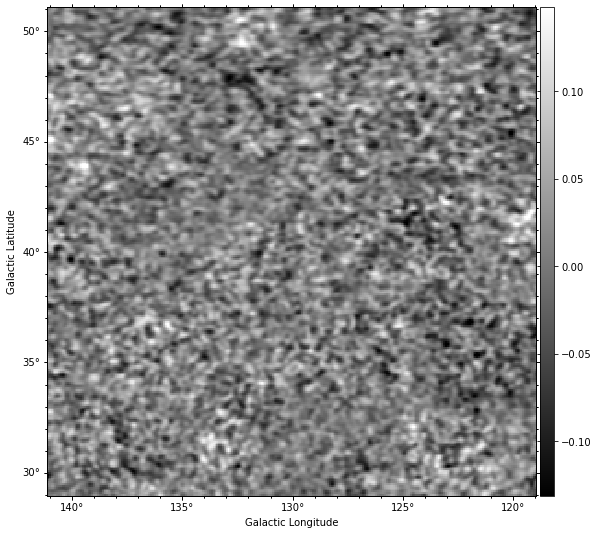

In [135]:
cube[200, :, :].quicklook()  # Slice the cube along the spectral axis, and display a quick image

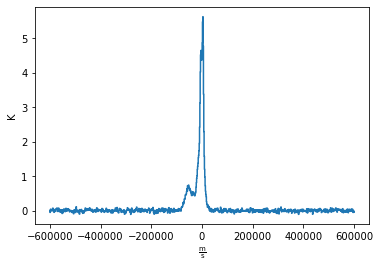

In [136]:
cube[:, 40, 10].quicklook()  # Extract a single spectrum through the data cube

In [137]:
_, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :]  #extract longitude world coordinates from cube

In [138]:
# Define desired latitude and longitude range
lat_range = [-46, -40] * u.deg
lon_range = [306, 295] * u.deg

# Create a sub_cube cut to these coordinates
sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])

print(sub_cube)

SpectralCube with shape=(933, 1, 1) and unit=K:
 n_x:      1  type_x: GLON-CAR  unit_x: deg    range:   141.083333 deg:  141.083333 deg
 n_y:      1  type_y: GLAT-CAR  unit_y: deg    range:    29.000000 deg:   29.000000 deg
 n_s:    933  type_s: VRAD      unit_s: m / s  range:  -600207.218 m / s:  600409.133 m / s


In [139]:
sub_cube_slab = cube.spectral_slab(-500. *u.km / u.s, 500. *u.km / u.s)

print(sub_cube_slab)

SpectralCube with shape=(777, 266, 266) and unit=K:
 n_x:    266  type_x: GLON-CAR  unit_x: deg    range:   119.000000 deg:  141.083333 deg
 n_y:    266  type_y: GLAT-CAR  unit_y: deg    range:    29.000000 deg:   51.083333 deg
 n_s:    777  type_s: VRAD      unit_s: m / s  range:  -499726.451 m / s:  499928.365 m / s


You can then extract a sub_cube in the spatial coordinates of the cube

## Moment Maps

Moment maps are a useful analysis tool to study data cubes. In short, a moment is a weighted integral along an axis (typically the Spectral Axis) that can give information about the total Intensity (or column density), mean velocity, or velocity dispersion along lines of sight.

SpectralCube makes this very simple with the .moment() method. We can convert to friendlier spectral units of km/s and these new 2D projections can be saved as new FITS files, complete with modified WCS information as well.

In [140]:
moment_0 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
moment_1 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits')
# moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ', moment_0.unit)
print('Moment_1 has units of: ', moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  K km / s
Moment_1 has units of:  km / s


The WCSAxes framework in Astropy allows us to display images with different coordinate axes and projections.

As long as we have a WCS object associated with the data, we can transfer that projection to a matplotlib axis. SpectralCube makes it possible to access just the WCS object associated with a cube object.

In [141]:
print(moment_1.wcs)  # Examine the WCS object associated with the moment map

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR'  'GLAT-CAR'  
CRVAL : 130.0  0.0  
CRPIX : 134.0  -347.0000001392  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0833333333  0.0833333333  
NAXIS : 0  0


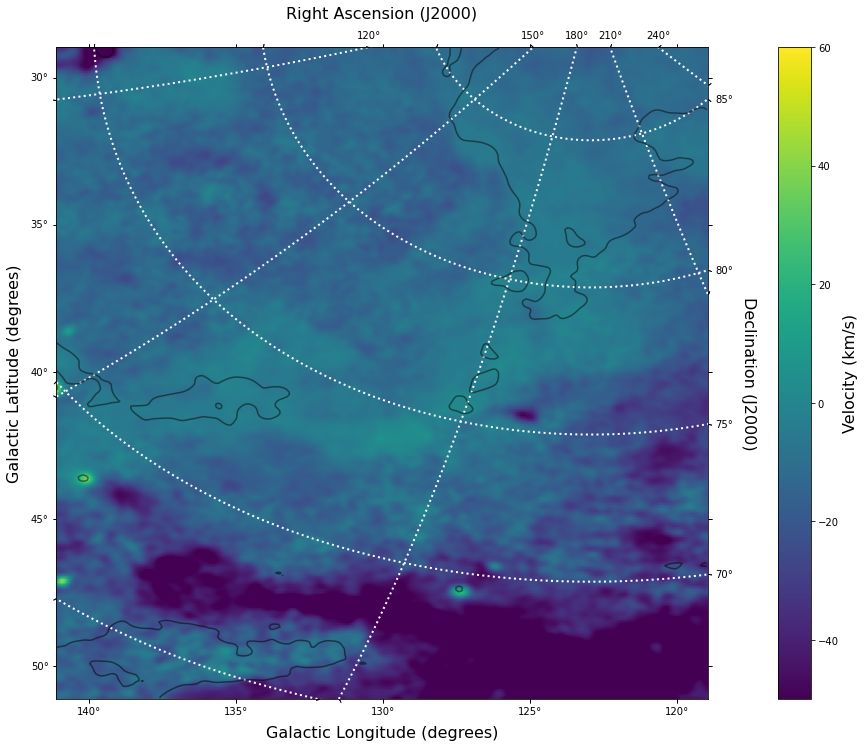

In [118]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='viridis', vmin=-50, vmax=60)
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22, 2e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

plt.savefig("High velocty Clouds from HI4PI Survey.jpg",dpi=500)
plt.show()


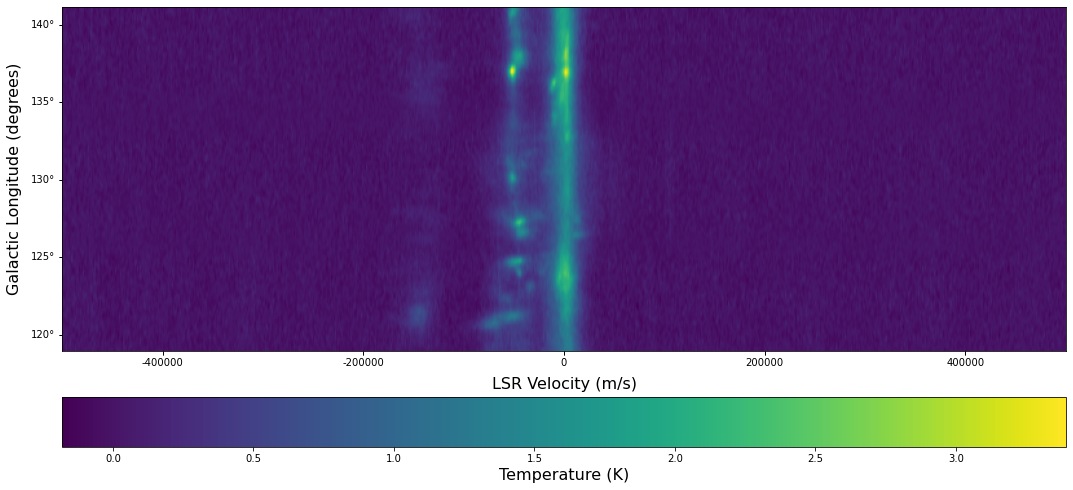

In [120]:
lat_slice = 200  # Index of latitude dimension to slice along

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=sub_cube_slab.wcs, slices=('y', lat_slice, 'x'))
# Above, we have specified to plot the longitude along the y axis, pick only the lat_slice
# indicated, and plot the velocity along the x axis

# Display the slice
im = ax.imshow(sub_cube_slab[:, lat_slice, :].transpose().data)  # Display the image slice
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("LSR Velocity (m/s)", fontsize=16)
ax.set_ylabel("Galactic Longitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Temperature (K)', size=16)

plt.savefig("Data slice showing longitude and velocity information.jpg",dpi=500)

In [142]:
def gauss(x, a, x0, sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))


def mean2vel(CRVAL, CDELT, CRPIX, mean):
    vel = [(CRVAL + CDELT * (mean[i] - CRPIX)) for i in range(len(mean))] #VLSR [km.s-1]                                                                                                                                                                                            
    return vel

def plot_map(image, nb_fig, xtitle, xlabel, ylabel, vmin, vmax, cbar_label, wcs, imkw):
    return fig

In [143]:
# Constant values
mh    = 1.6737236e-27 # kg
mu    = 1.25 * mh
k     = 1.38064852e-23 # J.K-1 --> m2.kg.s-2.K-1
G     = const.G.value # m3.kg-1.s-2
M_sun = const.M_sun.value # kg 

# Convertion tools
kpc2m  = u.kpc.to(u.m)
pc2cm  = u.pc.to(u.cm)

# HI4PI channel separation
dv = 1.29 #km.s-1

In [144]:
hdu_list_data = fits.open("CAR_G07.fits")
hdu_data = hdu_list_data[0]

In [145]:
cube = hdu_data.data
CDELT = hdu_data.header['CDELT3'] * 1.e-3 #km.s-1                                                                                                                                                                                                                           
CRVAL = hdu_data.header['CRVAL3'] * 1.e-3 #km.s-1                                                                                                                                                                                                                                   
CRPIX = hdu_data.header['CRPIX3']
reso = np.abs(CDELT)

In [146]:
#Plot total integrated density map
w = wcs.WCS(naxis=2)
w.wcs.crpix = [hdu_data.header['CRPIX1'], hdu_data.header['CRPIX2']]
w.wcs.cdelt = np.array([hdu_data.header['CDELT1'], hdu_data.header['CDELT2']])
w.wcs.crval = [hdu_data.header['CRVAL1'], hdu_data.header['CRVAL2']]
w.wcs.ctype = [hdu_data.header['CTYPE1'], hdu_data.header['CTYPE2']]

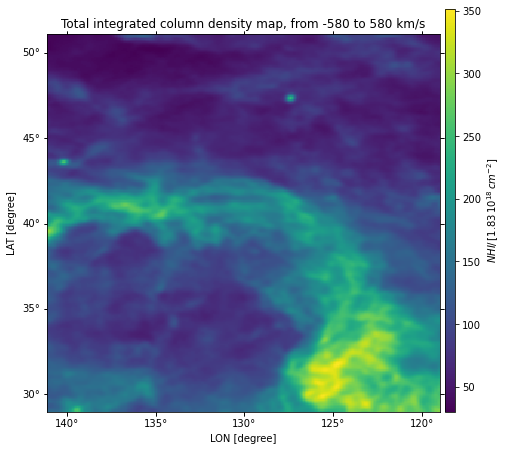

In [147]:
fig = plt.figure(0, figsize=(7, 7))
ax = fig.add_axes([0.1,0.1,0.78,0.75], projection=w)
ax.set_title("Total integrated column density map, from -580 to 580 km/s")
ax.set_xlabel("LON [degree]")
ax.set_ylabel("LAT [degree]")
img = ax.imshow(np.sum(cube,axis=0), aspect='auto', **imkw)
colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.set_label("$NHI/ \, [1.83 \, 10^{18} \, cm^{-2}]$")

plt.savefig("HVC field in the HI4PI Survey my analysis.jpg",dpi=500)

plt.show()

In [148]:
rms = 43.e-3 # K

velocity = np.array(mean2vel(CRVAL, CDELT, CRPIX, np.arange(cube.shape[0])))
idx = np.where((velocity < -185.) & (velocity > -225.))[0]

In [166]:
hvc1 = cube[idx, 146:155, 175:199]
hvc2 = cube[idx, 144:158, 172:202]
clean_hvc = np.copy(hvc2)
clean_hvc[np.where(hvc2 < 3. * rms)] = 0.

In [177]:
clean_hvc1 = np.copy(hvc1)
clean_hvc1[np.where(hvc1 < 1. * rms)] = 0.

In [178]:
# our actual data of the HVC 125+41-207
sum_clean_hvc = np.sum(clean_hvc, axis=0) 

In [179]:
sum_clean_hvc1 = np.sum(clean_hvc1, axis=0) 

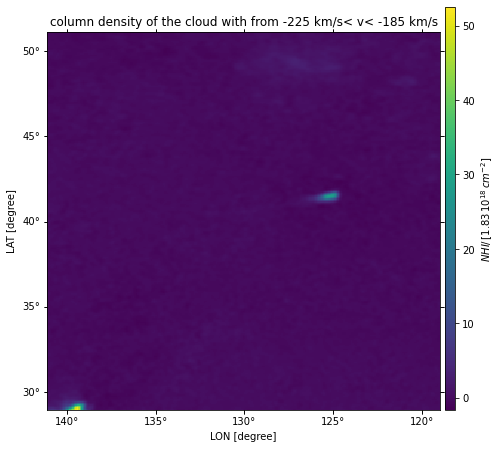

In [170]:
fig = plt.figure(1, figsize=(7, 7))
ax = fig.add_axes([0.1,0.1,0.78,0.75], projection=w)
ax.set_title("column density of the cloud with from -225 km/s< v< -185 km/s",fontsize=12)
ax.set_xlabel("LON [degree]")
ax.set_ylabel("LAT [degree]")
img = ax.imshow(np.sum(cube[idx,:,:],axis=0),aspect='auto', **imkw)
colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.set_label("$NHI/ \, [1.83 \, 10^{18} \, cm^{-2}]$")

plt.savefig("HVC Column density.jpg",dpi=500)
plt.show()


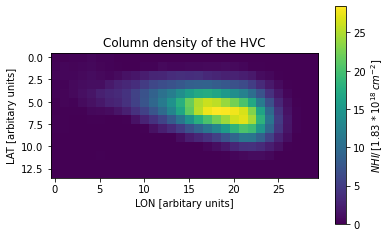

In [181]:
img = plt.imshow(sum_clean_hvc,cmap="viridis", interpolation = 'none')
cbar = plt.colorbar(img)
cbar.set_label("$NHI/ \, [1.83 \,* 10^{18} \, cm^{-2}]$")
plt.title("Column density of the HVC")
plt.xlabel("LON [arbitary units]")
plt.ylabel("LAT [arbitary units]")
plt.savefig("HVC clean map Column density.jpg",dpi=500)
plt.show()

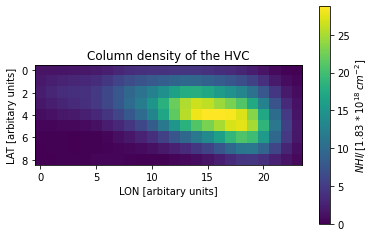

In [180]:
img2 = plt.imshow(sum_clean_hvc1,cmap="viridis", interpolation = 'none')
cbar = plt.colorbar(img2)
cbar.set_label("$NHI/ \, [1.83 \,* 10^{18} \, cm^{-2}]$")
plt.title("Column density of the HVC")
plt.xlabel("LON [arbitary units]")
plt.ylabel("LAT [arbitary units]")
plt.show()

In [183]:
spectra = np.mean(clean_hvc, axis=(1,2))
vel_spectra = velocity[idx]

In [184]:
x      = vel_spectra
y_real = spectra

In [185]:
n     = len(x)
mean  = np.sum(x * y_real) / np.sum(y_real) 
sigma = np.sqrt(np.sum((x - mean)**2 * y_real) / np.sum(y_real)) 

sigma

4.691778845351731

In [186]:
popt, pcov = curve_fit(gauss, x, y_real, p0 = [1, mean, sigma])

<ipython-input-142-e03c1c37c9f8>:2: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-x0)**2/(2*sigma**2))


<ipython-input-142-e03c1c37c9f8>:2: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-x0)**2/(2*sigma**2))


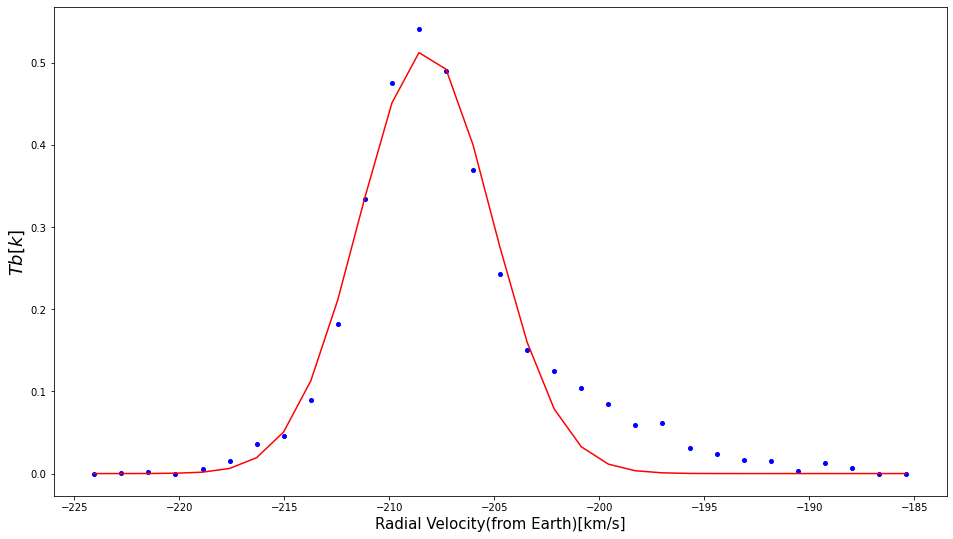

In [187]:
fig = plt.figure(3, figsize=(16,9))
ax1 = fig.add_subplot(111) 
ax1.set_xlabel('Radial Velocity(from Earth)[km/s]', fontsize=15)
ax1.set_ylabel('$Tb [k]$', fontsize=18)
ax1.plot(x, spectra, '.b', markersize=8, label ='warm')
ax1.plot(x, gauss(x,*popt), color='r')
plt.legend()
plt.show()

In [38]:
theta = np.radians(15. * (51-29)/266.)

In [39]:
NHI = 1.82243e18 * np.sum(spectra) * dv # in cm-2
density_surf = NHI * mh * pc2cm**2 / M_sun # Msun.pc-2
dispersion = popt[2] * 1.e3 # m/s
Tk  = mh * dispersion**2 / k # K

In [40]:
Tk

1200.8860100907893

In [41]:
density_surf

0.06641411311860074

In [42]:
#plt.plot(velocity,np.linspace(0,1200,933))

In [43]:
dispersion

3147.3902030983504

In [44]:
d    = np.arange(1000) + 1 # kpc
b    = 41 # deg
z    = d * np.sin(np.radians(b))

In [45]:
nHI  = (NHI/1.e-4) / theta / (d * kpc2m) *1.e-6 # cm-3
Ps_k = (nHI * Tk) - ((mu**2 * G * (NHI/1.e-4)**2 * np.pi / 15. / k)*1.e-6)# K.cm-3

In [46]:
#plt.plot(np.log(nHI),np.log(Ps_k))

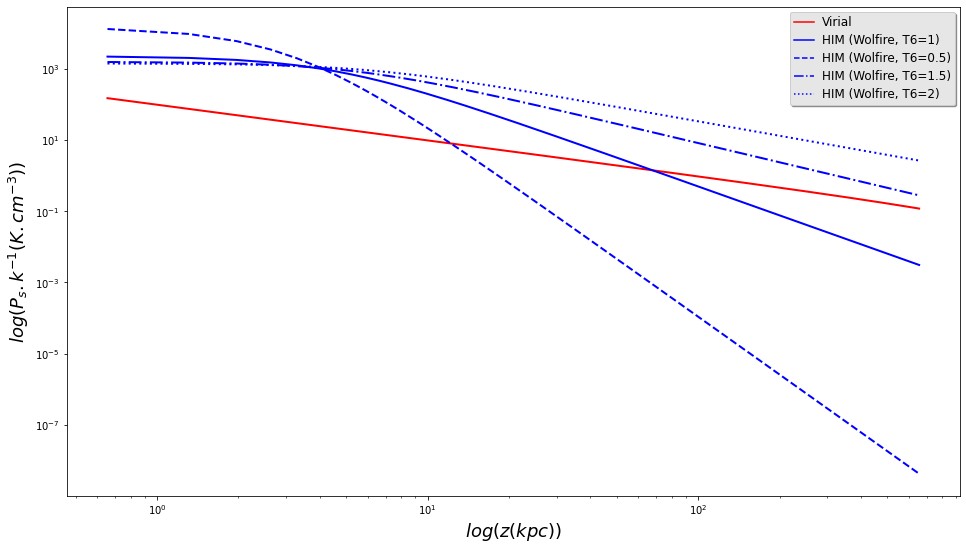

In [47]:
def P_k_Wolfire_1(z):
    return 2250. * (1 + (z**2 / 19.6))**(-1.35)

def P_k_Wolfire_0_5(z):
    return 2250. * (0.5 + (z**2 / 19.6))**(-1.35/0.5)

def P_k_Wolfire_1_5(z):
    return 2250. * (1.5 + (z**2 / 19.6))**(-1.35/1.5)

def P_k_Wolfire_2(z):
    return 2250. * (2 + (z**2 / 19.6))**(-1.35/2)

Ps_k_theory_1 = P_k_Wolfire_1(z)
Ps_k_theory_0_5 = P_k_Wolfire_0_5(z)
Ps_k_theory_1_5 = P_k_Wolfire_1_5(z)
Ps_k_theory_2 = P_k_Wolfire_2(z)

fig = plt.figure(4, figsize=(16,9))
ax1 = fig.add_subplot(111)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$log(z (kpc))$', fontsize=18)
ax1.set_ylabel('$log(P_s.k^{-1} (K.cm^{-3}))$', fontsize=18)
ax1.plot(z, Ps_k, color='r', linewidth=2., label='Virial')
ax1.plot(z, Ps_k_theory_1, color='b', linewidth=2., label='HIM (Wolfire, T6=1)')
ax1.plot(z, Ps_k_theory_0_5,'b--', linewidth=2., label='HIM (Wolfire, T6=0.5)')
ax1.plot(z, Ps_k_theory_1_5,'b-.', linewidth=2., label='HIM (Wolfire, T6=1.5)')
ax1.plot(z, Ps_k_theory_2,'b:', linewidth=2., label='HIM (Wolfire, T6=2)')

legend = ax1.legend(loc=1, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)
plt.show()

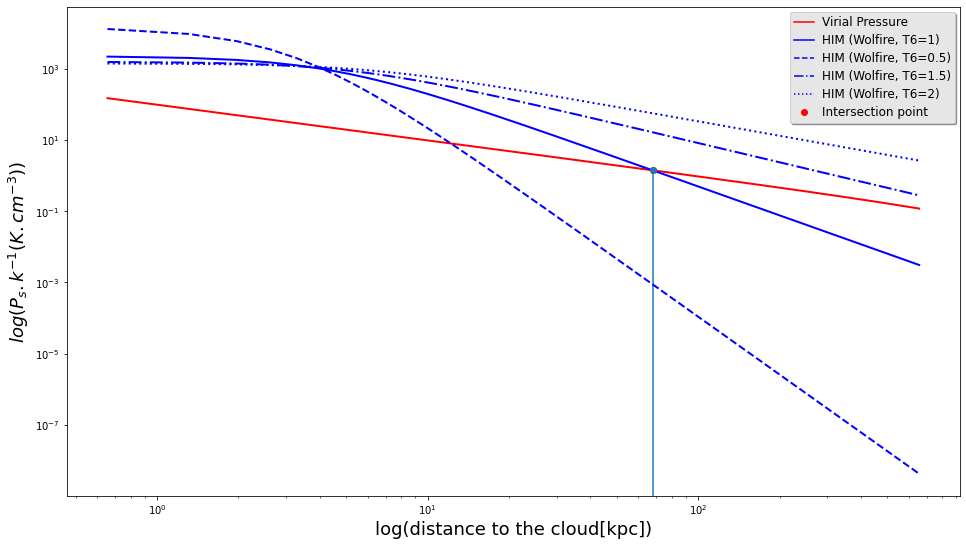

In [194]:
line_1= LineString(np.column_stack((z, Ps_k_theory_1)))
line_2= LineString(np.column_stack((z, Ps_k)))
intersection = line_1.intersection(line_2)


def P_k_Wolfire_1(z):
    return 2250. * (1 + (z**2 / 19.6))**(-1.35)

def P_k_Wolfire_0_5(z):
    return 2250. * (0.5 + (z**2 / 19.6))**(-1.35/0.5)

def P_k_Wolfire_1_5(z):
    return 2250. * (1.5 + (z**2 / 19.6))**(-1.35/1.5)

def P_k_Wolfire_2(z):
    return 2250. * (2 + (z**2 / 19.6))**(-1.35/2)

Ps_k_theory_1 = P_k_Wolfire_1(z)
Ps_k_theory_0_5 = P_k_Wolfire_0_5(z)
Ps_k_theory_1_5 = P_k_Wolfire_1_5(z)
Ps_k_theory_2 = P_k_Wolfire_2(z)

fig = plt.figure(4, figsize=(16,9))
ax1 = fig.add_subplot(111)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('log(distance to the cloud[kpc])', fontsize=18)
ax1.set_ylabel('$log(P_s.k^{-1} (K.cm^{-3}))$', fontsize=18)
ax1.plot(z, Ps_k, color='r', linewidth=2., label='Virial Pressure')
ax1.plot(z, Ps_k_theory_1, color='b', linewidth=2., label='HIM (Wolfire, T6=1)')
ax1.plot(z, Ps_k_theory_0_5,'b--', linewidth=2., label='HIM (Wolfire, T6=0.5)')
ax1.plot(z, Ps_k_theory_1_5,'b-.', linewidth=2., label='HIM (Wolfire, T6=1.5)')
ax1.plot(z, Ps_k_theory_2,'b:', linewidth=2., label='HIM (Wolfire, T6=2)')

plt.plot(*intersection.xy,'ro',label='Intersection point')

plt.stem(*intersection.xy)

legend = ax1.legend(loc=1, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)
    
plt.savefig("HVC distance.jpg",dpi=500)
plt.show()

In [49]:
x,y= intersection.xy

x,y

(array('d', [67.84536346626324]), array('d', [1.4098766826550733]))

In [50]:
dist_to_cloud=67.84 #kpc
dist_to_cloud

67.84

In [51]:
filename = get_pkg_data_filename('CAR_G07.fits')

In [52]:
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
image_data = hdu.data

In [53]:
temp_dist=(image_data[50,:,:])*0.001
temp_dist

array([[-4.9535625e-05, -5.0293034e-05, -2.5853140e-05, ...,
        -1.1740981e-05, -1.2739011e-05, -1.1429367e-05],
       [-5.5766312e-05, -6.4198568e-05, -4.7358266e-05, ...,
         1.3683536e-05,  8.5569109e-06,  8.6617983e-06],
       [-3.6960380e-05, -5.0199618e-05, -5.4506840e-05, ...,
        -1.0533404e-05, -5.8113246e-06, -4.5779207e-06],
       ...,
       [ 3.1558673e-05,  2.1146046e-05,  1.6210037e-05, ...,
         6.5460597e-05,  5.5530640e-05,  4.2197986e-05],
       [ 3.0096635e-05,  1.4151542e-05,  1.5811621e-06, ...,
         5.9176520e-05,  5.4917575e-05,  5.0847848e-05],
       [ 2.1904789e-05,  9.0946996e-06, -2.5559975e-06, ...,
         4.7612579e-05,  4.8046055e-05,  4.5415487e-05]], dtype=float32)

In [54]:
#hdu.header

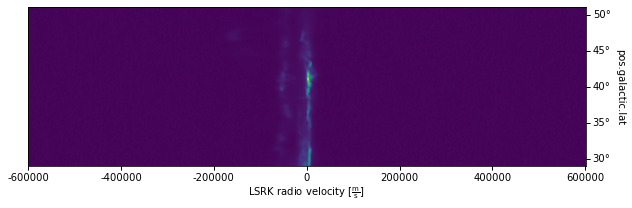

In [55]:
f = plt.figure(figsize=(10,3))
ax = plt.subplot(projection=wcs, slices=(-185, 'y', 'x'))
ax.coords[2].set_ticklabel(exclude_overlapping=True)
ax.imshow(image_data[:, :, -225].transpose())

In [56]:
#f = plt.figure(figsize=(3,10))
#ax = plt.subplot(projection=wcs, slices=(50, 'x', 'y'))
#ax.imshow(image_data[:, :, 50])

In [57]:
#ax.set(xlim=(-600, 600), ylim=(0, 8))

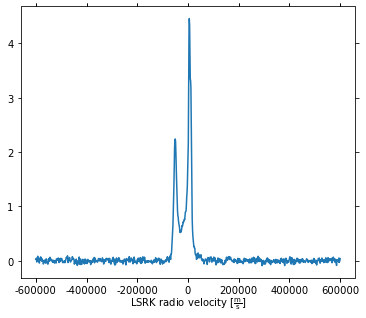

In [58]:
f = plt.figure(figsize=(6,5))

ax = plt.subplot(projection=wcs, slices=(100, 100, 'x')) 
#ax.set(xlim=(0,100), ylim=(0, 8))

ax.plot(image_data[:,100,100])

#plt.xlim(100,1000)
plt.show()

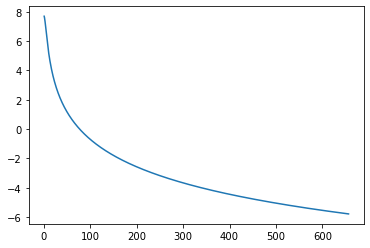

In [59]:
plt.plot(z,np.log(Ps_k_theory_1))

### virial parameter calculation

α=5σ²R/GM
     
M=4/3*pi*R^3 * Rho
      
Rho =u*NHI*(2R)^-1
      
R=1/2)*theta*d
      
d

In [60]:
R = 0.5 *0.025* dist_to_cloud*(3.086e+21) #cm
R

2.6169280000000005e+21

In [61]:
nhi= 1e+21 #cm^-2

In [62]:
#density
rho= (nhi*2.08e-27*1000)/(2*R)
rho

3.9741253867129692e-25

In [190]:
# mass
M= ((4/3)*(np.pi)*(R**3)*rho)
M

2.983358859866518e+40

In [191]:
#virial parameter

alpha = (5*(dispersion**2)*R)/(6.67e-8*M)
alpha
# hence it is gravitationally bound

6.513758083700723e-05

In [65]:
# free fall time

tff= np.sqrt((3*np.pi)/(32*6.67e-8*rho))
tff

3333318977904119.5

In [73]:
hi4pi = get_pkg_data_filename('hi4pi-hvc-nhi-car.fits')


In [67]:
hi4pi.info()

Filename: hi4pi-hvc-nhi-car.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      33   (4323, 2144)   float32   


In [74]:
hdu = fits.open(hi4pi)[0]
wcs = WCS(hdu.header)
image_data = hdu.data

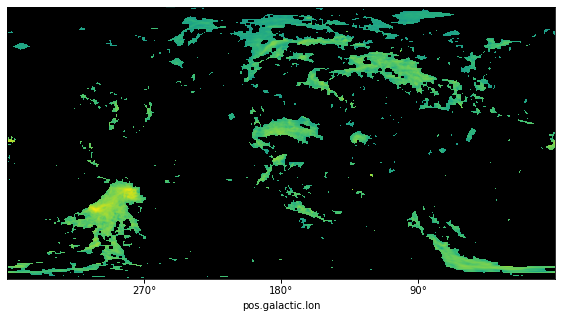

In [89]:
f = plt.figure(figsize=(10,5))
ax = plt.subplot(111,projection=wcs)
#ax.coords[2].set_ticklabel(exclude_overlapping=True)
ax.imshow(image_data)

